# HR Separation 
## Assessment of the survival models (and my modifications to lifelines)


In [1]:
stgdir1local = u'C:/Users/kesj/Documents/projects/HRattrition/survival'
repodir = u'C:/Users/kesj/code/'

In [2]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
os.chdir(stgdir1local)

## load the model

In [4]:
import pickle

In [5]:
mdl_filename='separation_cf4.pkl'
s_cf4 = pickle.load(open(mdl_filename,'rb'))

In [6]:
import lifelines

### Load the dataset

In [7]:
empl1 = pd.read_csv('after2001_v8.csv',dtype={'KEY':np.str,'EEO1CODE':np.str},parse_dates=['birth_tstmp','term_tstmp','hire_tstmp'])

In [8]:
empl1.EEO1CODE.unique()

array(['2', '5', '1', '4', '3', '7', '6', 'N', 'L', '8'], dtype=object)

In [9]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import ensemble, metrics, cross_validation

In [13]:
#import sklearn.discriminant_analysis.LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [10]:
os.chdir(repodir)
import bear.bear as br
#os.chdir(stgdir1local)
reload(br)

C:\Anaconda\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


<module 'bear.bear' from 'bear\bear.pyc'>

In [28]:
os.chdir(stgdir1local)
empl1[empl1.status==0].to_csv('current_v8.ssv',sep=';',index=False)

In [18]:
os.chdir('../reduced/')

In [20]:
empl2 = pd.read_csv('after2001_v3.csv',dtype={'KEY':np.str})
print(empl2.shape)

(134266, 69)


In [24]:
[col for col in empl1.columns if col.endswith('DT')]

['HIRE_DT', 'LAST_HIRE_DT', 'SERVICE_DT', 'TERMINATION_DT']

In [25]:
empl1[['HIRE_DT','BIRTHDATE']].head()

,HIRE_DT,BIRTHDATE
0,1969-01-22,1949-09-27
1,2014-06-09,1993-09-05
2,2012-12-10,1988-02-24
3,1985-10-14,1950-02-14
4,2012-06-04,1991-04-12


In [21]:
empl2[empl2.status==0].columns

Index([u'EXT_FUNC_ID_SFI', u'EEO1CODE', u'REH_CNT', u'birth_tstmp', u'retired',
       u'FULL_PART_TIME', u'EMPL_CLASS', u'SHIFT', u'FLSA_STATUS',
       u'LOC_STATE', u'TOTAL_RPT_CNT', u'INTERN', u'GRADE', u'FUNCCNT1',
       u'PERF1', u'DEPENDENT_CNT', u'SUPVCNT1', u'Tenure_years', u'JOB_FAMILY',
       u'ANNUAL_RT', u'hire_tstmp', u'REMOTE', u'DIVISION_CODE_SFI',
       u'COMPANY', u'FLOORCNT1', u'FUNC_CNT', u'SEX', u'ETHNIC_GROUP',
       u'RELOCATE_ALL_SFI', u'LOCATION', u'HUBIND', u'PARTFULL1', u'STD_HOURS',
       u'JOBCNT1', u'term_tstmp', u'MIN_RT_ANNUAL', u'FLOR_SFI', u'PTFTCNT1',
       u'KEY', u'FULLPART1', u'FTPTCNT1', u'GRADECNT1', u'EFUNCCNT1',
       u'hire_age', u'HAVE_INS', u'FTE', u'JOB_FUNCTION', u'SAL1',
       u'LOCSTCNT1', u'former', u'EMPL_TYPE', u'EXTFUNC_CNT', u'JOBCODE',
       u'SUPV_DIFF_LOC', u'Age_years', u'ADDRCNT1', u'RELO_STATE_CNT_SFI',
       u'HAVE_DEP', u'REMOTE_SUPV', u'MAX_RT_ANNUAL', u'LOCCNT1', u'status',
       u'DIRECT_RPT_CNT', u'MERIT1', u'

## Preprocess this file
1. use the dictonary fro LOC_TYPE_DESCR_SFI 

In [11]:
loc_descriptions = empl1.LOC_TYPE_DESCR_SFI.unique().tolist()
short_loc_descript = {}
for loc_name in loc_descriptions:
    if loc_name.endswith(')'):
        short_name = loc_name[-4:-1]
        if short_name == 'NCE':
            short_loc_descript[loc_name]='TELE'
        else:
            short_loc_descript[loc_name]=short_name
    elif loc_name.startswith('TELE'):
        short_loc_descript[loc_name]='TELE'
    elif loc_name.endswith('SIU'):
        short_loc_descript[loc_name]='SIU'
    elif loc_name.startswith('OPERATIONS'):
        short_loc_descript[loc_name]='OC'
    elif loc_name.startswith('CORP'):
        short_loc_descript[loc_name]='CORP'
    elif loc_name.endswith('CENTER'):
        short_loc_descript[loc_name]='MC' # marketing center
    elif loc_name.endswith('AFO'):
        short_loc_descript[loc_name]='AFO'
    elif loc_name.endswith('OFFICE'):
        if loc_name.startswith('AGENT'):
            short_loc_descript[loc_name]='AO' # agent office
        elif loc_name.startswith('REGION'):
            short_loc_descript[loc_name]='RO' # regional office
        elif loc_name.startswith('CATA'):
            short_loc_descript[loc_name]='CAT' # catastrophe office
    elif loc_name.startswith('EST'):
        short_loc_descript[loc_name]='EST' # estimating station
    elif loc_name.startswith('ADM'):
        short_loc_descript[loc_name]='ADM' # estimating station
    elif loc_name.startswith('WARE'):
        short_loc_descript[loc_name]='WARE' # estimating station
    elif loc_name.startswith('VAC'):
        short_loc_descript[loc_name]='VAC' # estimating station
    elif loc_name.startswith('MULT-USE'):
        short_loc_descript[loc_name]='MF' # estimating station
    elif loc_name.startswith('MULT-REG'):
        short_loc_descript[loc_name]='MRSF' # estimating station
    else: 
        short_loc_descript[loc_name]='UNK'

print len(short_loc_descript.keys()), len(set(short_loc_descript.values()))

31 21


In [12]:
empl1['loc_desc']=empl1['LOC_TYPE_DESCR_SFI'].apply(lambda x: short_loc_descript[x])


In [13]:
### Define the categorical columns
cat_cols = br.get_categorical(empl1)
print len(cat_cols)
cat_cols.remove('LOC_TYPE_DESCR_SFI')

36


In [27]:
cols_to_drop = ['Age_tdelta','Tenure_tdelta','BIRTHDATE','HIRE_DT','LAST_HIRE_DT','SERVICE_DT','TERMINATION_DT','KEY']

In [28]:
for col in cols_to_drop:
    cat_cols.remove(col)

In [29]:
sdf_cat = br.summarize_dataframe(empl1[cat_cols])
max_arity = 33
binary_cat_cols = sdf_cat[sdf_cat.arity==2].feature.tolist()
cat_cols_to_dummy = sdf_cat[(sdf_cat.arity < max_arity) & (sdf_cat.arity > 2)].sort_values(by='arity').feature.tolist()
cat_cols_to_label_encode = sdf_cat[sdf_cat.arity >= max_arity].feature.tolist()
print len(sdf_cat), len(cat_cols_to_label_encode),len(cat_cols_to_dummy), len(binary_cat_cols)



27 3 8 16


In [30]:
binary_cat_cols


['COMP_FREQUENCY',
 'FULLPART1',
 'FULLPART10',
 'FULLPART3',
 'FULLPART5',
 'HUBIND',
 'INTERN',
 'PARTFULL1',
 'PARTFULL10',
 'PARTFULL3',
 'PARTFULL5',
 'RELOCATE_ALL_SFI',
 'REMOTE',
 'REMOTE_SUPV',
 'SEX',
 'SUPV_DIFF_LOC']

In [31]:
cat_cols_to_dummy

['FLSA_STATUS',
 'EMPL_TYPE',
 'FULL_PART_TIME',
 'SHIFT',
 'EMPL_CLASS',
 'EEO1CODE',
 'JOB_FUNCTION',
 'loc_desc']

In [32]:
cat_cols_to_label_encode

['GRADE', 'JOB_FAMILY', 'LOC_STATE']

In [33]:
binary_cat_cols.remove('FULLPART10')
binary_cat_cols.remove('FULLPART3')
binary_cat_cols.remove('FULLPART5')
binary_cat_cols.remove('PARTFULL10')
binary_cat_cols.remove('PARTFULL5')
binary_cat_cols.remove('PARTFULL3')


In [34]:
sdf_cat[sdf_cat.arity>=max_arity]

,feature,datatype,nmissing,arity,accepted values,x_missing
10,GRADE,int64,0,123,Too many to show,0
13,JOB_FAMILY,int64,0,1448,Too many to show,0
15,LOC_STATE,int64,0,52,Too many to show,0


In [35]:
missing_cols = br.get_columns_with_nulls(empl1)

In [36]:
all_cols = empl1.columns.tolist()

In [37]:
missing_cols

['MERIT1', 'PERF1']

In [38]:
from sklearn.preprocessing import LabelEncoder
#binary_cols = #sdf_cat[sdf_cat.arity == 2].feature.values.tolist()
#binary_cat_cols = cat_cols_to_label_encode[:-3]
print len(binary_cat_cols)
label_encoder = LabelEncoder()
for col in binary_cat_cols:
    print col, len(empl1[col].unique()), empl1[col].unique()
    empl1[col] = label_encoder.fit_transform(empl1[col]) # use sklearn.preprocesing.LabelEncoder()
    

10
COMP_FREQUENCY 2 ['A' 'H']
FULLPART1 2 ['N' 'Y']
HUBIND 2 ['N' 'Y']
INTERN 2 ['N' 'Y']
PARTFULL1 2 ['N' 'Y']
RELOCATE_ALL_SFI 2 ['N' 'Y']
REMOTE 2 ['N' 'Y']
REMOTE_SUPV 2 ['N' 'Y']
SEX 2 ['F' 'M']
SUPV_DIFF_LOC 2 ['Y' 'N']


In [39]:
historical_cols10 = [col for col in all_cols if col.endswith('10')]
mos_cols = [col for col in all_cols if col.endswith('MOS')]
print historical_cols10

print mos_cols
historical_cols5 = [col for col in all_cols if col.endswith('5')]#[:-3]
historical_cols3 =[col for col in all_cols if col.endswith('3')]#[:-4]

len(historical_cols3), len(historical_cols5),len(historical_cols10), len(mos_cols)

['ADDRCNT10', 'DEPTCNT10', 'EFUNCCNT10', 'FLOORCNT10', 'FTPTCNT10', 'FULLPART10', 'FUNCCNT10', 'GRADECNT10', 'JOBCNT10', 'LOCCNT10', 'LOCSTCNT10', 'PARTFULL10', 'PTFTCNT10', 'SUPVCNT10']
['CUR_DEPT_MOS', 'CUR_EFUNC_MOS', 'CUR_FUNC_MOS', 'CUR_GRADE_MOS', 'CUR_JOB_MOS', 'CUR_LOC_MOS', 'TELE_MOS']


(14, 14, 14, 7)

In [40]:
historical_cols = []
historical_cols+=historical_cols3
historical_cols+=historical_cols5
historical_cols+=historical_cols10
print len(historical_cols)

42


In [41]:
modeling_cols = [col for col in all_cols if col not in historical_cols]
for col in cols_to_drop:
    modeling_cols.remove(col)

for col in all_cols:
    if col.endswith('tstmp'):
        modeling_cols.remove(col)
        
modeling_cols.remove('hire_age')
modeling_cols.remove('status')
modeling_cols.remove('sep_status')
modeling_cols.remove('retired')
modeling_cols.remove('ANNUAL_RT') # use SAL1 instead

len(modeling_cols)

69

## Restrict to non-retired
## create a train/test split

In [42]:
nr_em = empl1[empl1.retired==0].copy()
nr_em.shape

(119326, 127)

In [43]:
## break this into a test/train 
# break into evaluation and build sets
print "Starting with subset of {0} employees.".format(len(nr_em))
eval_fraction = 0.20
ne2build, ne2eval = cross_validation.train_test_split(nr_em,test_size=eval_fraction,random_state = 60333)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(ne2eval),len(ne2build))

Starting with subset of 119326 employees.
Evaluation set has 23866 employees; training set has 95460 employees.


In [47]:
#from sklearn import preprocessing
pipe = Pipeline([("null", br.RemoveAllNull()),  
                 ("label_encode",br.LabelEncodeColumn(cat_cols_to_label_encode)),
                 ("dummy_encode", br.DummyEncodeColumn(cat_cols_to_dummy)),
                 #("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),
                 #("cat", br.ConvertCategorical(cate_list, rows_to_scan=0.3)),
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1'],
                                                    criteria_coef=('percentile',2),
                                                   method='lower',fill_with='nearest_value')),
                  ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'],criteria_coef=('percentile',2),
                                                   method='both',fill_with='nearest_value')),
                 #("fill_missingzero",FillMissingValue(columns_to_fix=['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT'],fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=missing_cols,rows_to_scan=0.8))])
                 

In [48]:
p_pipe = Pipeline([
                  ("label_encode",br.LabelEncodeColumn(cat_cols_to_label_encode))])

In [52]:
#%pdb 
ne2b = pipe.fit_transform(ne2build[modeling_cols],ne2build.terminated)
ne2e = pipe.fit(ne2build[modeling_cols],ne2build.terminated).transform(ne2eval[modeling_cols])

In [53]:
ne2b.shape, ne2e.shape

((95460, 123), (23866, 123))

In [54]:
transformed_cols2 = ne2b.columns.tolist()
print len(transformed_cols2)

123


In [58]:
sep_features= s_cf4.data.columns.tolist()
print len(sep_features)

16


In [59]:
s_cf4.print_summary()

n=76368, number of events=31927

                       coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
Age_years        -9.386e-01  3.912e-01 1.023e-02 -9.175e+01  0.000e+00  -9.587e-01  -9.185e-01  ***
SAL1             -1.115e+00  3.278e-01 1.479e-02 -7.539e+01  0.000e+00  -1.144e+00  -1.086e+00  ***
MERIT1            2.742e-01  1.315e+00 6.343e-03  4.323e+01  0.000e+00   2.618e-01   2.866e-01  ***
PERF1            -1.016e-01  9.034e-01 1.240e-02 -8.195e+00  2.514e-16  -1.259e-01  -7.730e-02  ***
BOX1             -4.839e-01  6.164e-01 6.824e-03 -7.090e+01  0.000e+00  -4.972e-01  -4.705e-01  ***
SEX               1.643e-01  1.179e+00 6.098e-03  2.695e+01 5.826e-160   1.524e-01   1.763e-01  ***
HAVE_INS         -3.066e-01  7.359e-01 9.072e-03 -3.380e+01 1.975e-250  -3.244e-01  -2.888e-01  ***
HAVE_DEP         -2.326e-01  7.925e-01 1.147e-02 -2.027e+01  2.258e-91  -2.550e-01  -2.101e-01  ***
DEPTCNT1         -3.471e-01  7.068e-01 9.569e-03 -3.627e+01 4.495e-

## now apply this model to the evaluation set
1. calculate concordance for hold-out set

In [60]:
from lifelines.utils import concordance_index
def return_concordance(df,model,time_col,event_col):
    c_index = concordance_index(df[time_col].values,
                               model.predict_expectation(df).values.ravel(),
                               df[event_col].values.astype(int))
    return c_index

In [62]:
sep_cols = [col for col in sep_features]
sep_cols.append('Tenure_years')
sep_cols.append('terminated')

In [63]:
return_concordance(ne2e[sep_cols],s_cf4,'Tenure_years','terminated')

0.88715965871132707

In [64]:
## do this for a small set 1st
take20 = ne2e.head(20).copy()

In [65]:
return_concordance(take20[sep_cols],s_cf4,'Tenure_years','terminated')

0.93518518518518523

## Forecast forward in 1 year intervals
1. identify time points for each row
2. predict SF and CI for these

In [266]:
def identify_time_points(mdl, df, yr_range=[0,1,2,3,4,5],base_time_col = 'Tenure_years'):
    column_names = ['time_point_'+np.str(year) for year in yr_range]
    
    my_index = df.index.tolist()
    relevant_time_points = pd.DataFrame(columns=column_names, index=my_index)
    for idx in my_index:
        my_times = np.array([df.loc[idx,base_time_col]+year for year in yr_range])
        #print idx, my_times
        #relevant_time_points.append(pd.DataFrame(data = my_times.T, columns=column_names))
        relevant_time_points.ix[idx] = my_times
        # now for each of these
    return relevant_time_points

In [91]:
#get_relevant_baseline_sf(s_cf4, take20[sep_cols])
rtp_df = identify_time_points(s_cf4, take20[sep_cols])

25915 [ 0.6625735  1.6625735  2.6625735  3.6625735  4.6625735  5.6625735]
129486 [ 2.57637049  3.57637049  4.57637049  5.57637049  6.57637049  7.57637049]
14289 [ 11.55122966  12.55122966  13.55122966  14.55122966  15.55122966
  16.55122966]
29041 [ 17.12287042  18.12287042  19.12287042  20.12287042  21.12287042
  22.12287042]
48029 [ 25.555624  26.555624  27.555624  28.555624  29.555624  30.555624]
59412 [ 24.30987632  25.30987632  26.30987632  27.30987632  28.30987632
  29.30987632]
65674 [ 3.54558957  4.54558957  5.54558957  6.54558957  7.54558957  8.54558957]
65872 [ 12.68198526  13.68198526  14.68198526  15.68198526  16.68198526
  17.68198526]
70843 [ 13.28980061  14.28980061  15.28980061  16.28980061  17.28980061
  18.28980061]
46577 [ 15.6279732  16.6279732  17.6279732  18.6279732  19.6279732  20.6279732]
86579 [ 11.70181455  12.70181455  13.70181455  14.70181455  15.70181455
  16.70181455]
93871 [ 21.4898321  22.4898321  23.4898321  24.4898321  25.4898321  26.4898321]
33172 [ 1

In [92]:
rtp_df.head()

,time_point_0,time_point_1,time_point_2,time_point_3,time_point_4,time_point_5
25915,0.662573,1.66257,2.66257,3.66257,4.66257,5.66257
129486,2.57637,3.57637,4.57637,5.57637,6.57637,7.57637
14289,11.5512,12.5512,13.5512,14.5512,15.5512,16.5512
29041,17.1229,18.1229,19.1229,20.1229,21.1229,22.1229
48029,25.5556,26.5556,27.5556,28.5556,29.5556,30.5556


## compare against predict_survival_function

In [93]:
pred_sf = s_cf4.predict_survival_function(take20[sep_cols])
pred_sf.shape

(9867, 20)

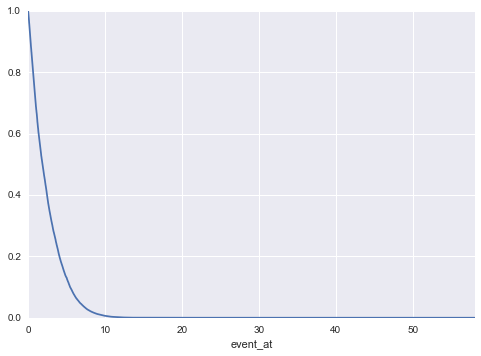

In [95]:
pred_cumhaz = s_cf4.predict_cumulative_hazard(take20[sep_cols])
pred_cumhaz.shape

(9867, 20)

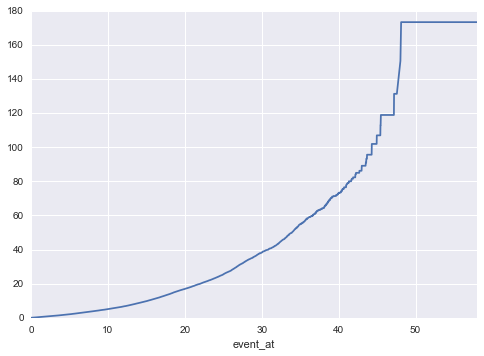

In [96]:
pred_cumhaz[25915].plot()

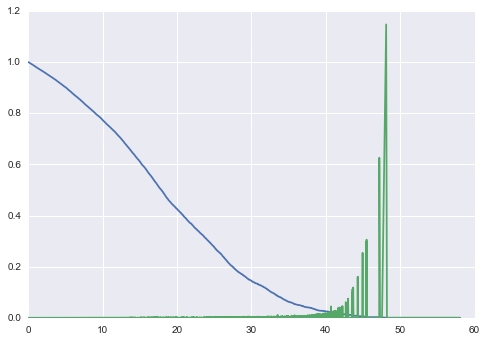

In [98]:
s_0 = s_cf4.baseline_survival_
h_0 = s_cf4.baseline_hazard_
plt.plot(s_0)
plt.plot(h_0)

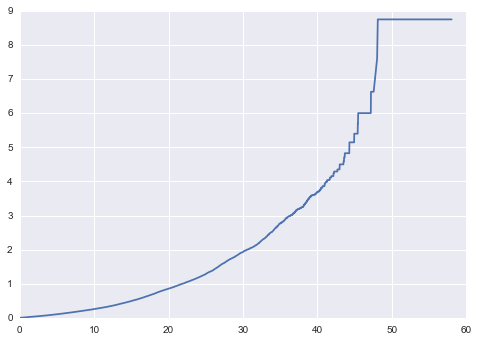

In [99]:
plt.plot(s_cf4.baseline_cumulative_hazard_)

In [100]:
s_cf4.baseline_cumulative_hazard_.head()

,baseline hazard
event_at,
0.000000,0.000048
0.002738,0.000085
0.005476,0.000128
0.008214,0.000174
0.010952,0.000212


In [101]:
s_cf4.hazards_

,Age_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP,DEPTCNT1,EXTFUNC_CNT,FUNC_CNT,REMOTE,DIRECT_RPT_CNT,HUBIND,REH_CNT,JOB_FUNCTION_PSA
coef,-0.938603,-1.115258,0.274205,-0.101613,-0.483857,0.164341,-0.306632,-0.232554,-0.347074,0.095909,-0.150437,-0.154638,0.156904,-0.083375,-0.23303,-0.0755


In [102]:
s_cf4.confidence_intervals_

,Age_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP,DEPTCNT1,EXTFUNC_CNT,FUNC_CNT,REMOTE,DIRECT_RPT_CNT,HUBIND,REH_CNT,JOB_FUNCTION_PSA
lower-bound,-0.958658,-1.144260,0.261769,-0.125921,-0.497236,0.152386,-0.324417,-0.255043,-0.365832,0.084936,-0.166429,-0.176518,0.149126,-0.096632,-0.245819,-0.088828
upper-bound,-0.918548,-1.086256,0.286641,-0.077304,-0.470479,0.176296,-0.288848,-0.210065,-0.328316,0.106882,-0.134445,-0.132758,0.164682,-0.070119,-0.220242,-0.062172


In [103]:
s_cf4.baseline_hazard_.head()

,baseline hazard
event_at,
0.000000,0.000048
0.002738,0.000037
0.005476,0.000043
0.008214,0.000047
0.010952,0.000037


In [104]:
rtp_df.head()

,time_point_0,time_point_1,time_point_2,time_point_3,time_point_4,time_point_5
25915,0.662573,1.66257,2.66257,3.66257,4.66257,5.66257
129486,2.57637,3.57637,4.57637,5.57637,6.57637,7.57637
14289,11.5512,12.5512,13.5512,14.5512,15.5512,16.5512
29041,17.1229,18.1229,19.1229,20.1229,21.1229,22.1229
48029,25.5556,26.5556,27.5556,28.5556,29.5556,30.5556


In [114]:
s_cf4.baseline_hazard_.ix[:rtp_df.iloc[0]['time_point_0']]#.values[-10:]

,baseline hazard
event_at,
0.000000,0.000048
0.002738,0.000037
0.005476,0.000043
0.008214,0.000047
0.010952,0.000037
0.013690,0.000006
0.016427,0.000021
0.019165,0.000037
0.021903,0.000042


In [120]:
s_cf4.baseline_hazard_.ix[rtp_df.iloc[0]['time_point_0']]#.values[-10:]

baseline hazard    0.00014
Name: 0.662573495691, dtype: float64

In [132]:
for tp in rtp_df.columns:
    
    tp_idx = rtp_df.iloc[0][tp]
    print tp, tp_idx
    try: 
        spec_hazard = s_cf4.baseline_hazard_.ix[tp_idx].values
        c_haz = s_cf4.baseline_cumulative_hazard_.ix[tp_idx].values
        print spec_hazard, c_haz
    except KeyError:
        print " _______\n keyError " #,tp_idx
        t_post = s_cf4.baseline_hazard_.ix[tp_idx:].index[0] # get the first after this point
        t_prior = s_cf4.baseline_hazard_.ix[:tp_idx].index[-1] # get the last before this point
        print s_cf4.baseline_hazard_.ix[t_post], s_cf4.baseline_hazard_.ix[t_prior]
        
#s_cf4.baseline_hazard_.ix[rtp_df.iloc[0]['time_point_1']]

time_point_0 0.662573495691
[ 0.00013963] [ 0.01184655]
time_point_1 1.66257349569
 _______
 keyError 
baseline hazard    0.000026
Name: 1.66464746025, dtype: float64 baseline hazard    0.000016
Name: 1.66190955324, dtype: float64
time_point_2 2.66257349569
 _______
 keyError 
baseline hazard    0.000053
Name: 2.6639835178, dtype: float64 baseline hazard    0.000008
Name: 2.66124561079, dtype: float64
time_point_3 3.66257349569
 _______
 keyError 
baseline hazard    0.000031
Name: 3.66331957535, dtype: float64 baseline hazard    0.000061
Name: 3.66058166834, dtype: float64
time_point_4 4.66257349569
 _______
 keyError 
baseline hazard    0.000041
Name: 4.6626556329, dtype: float64 baseline hazard    0.000041
Name: 4.65991772589, dtype: float64
time_point_5 5.66257349569
 _______
 keyError 
baseline hazard    0.000277
Name: 5.66472959746, dtype: float64 baseline hazard    0.000104
Name: 5.66199169045, dtype: float64


In [156]:
s_cf4.baseline_cumulative_hazard_.ix[s_cf4.baseline_cumulative_hazard_.ix[:0.002738].index[-1]].values

array([  8.45533318e-05])

In [159]:
from scipy import interpolate
def return_desired_cumulative_hazards(t):
    mdl = s_cf4
    
    try: 
        spec_hazard = mdl.baseline_hazard_.ix[t].values
        c_haz = mdl.baseline_cumulative_hazard_.ix[t].values[0]
        #print spec_hazard, c_haz
    except KeyError:
        #t_1 = s_cf4.baseline_cumulative_hazard_
        t_post = mdl.baseline_hazard_.ix[t:].index[0] # get the first after this point
        t_prior = mdl.baseline_hazard_.ix[:t].index[-1] # get the last before this point
        x = [t_prior, t_post]
        y = [mdl.baseline_cumulative_hazard_.ix[t_prior].values[0],mdl.baseline_cumulative_hazard_.ix[t_post].values[0]]
        #print x, y
        chaz_interp = interpolate.interp1d([t_prior,t_post],y)
        c_haz = chaz_interp(t)
    return c_haz

In [167]:
s_cf4.baseline_cumulative_hazard_.ix[rtp_df.iloc[0]['time_point_0']]

baseline hazard    0.011847
Name: 0.662573495691, dtype: float64

In [173]:
#rtp_df[['time_point_1','time_point_2']].applymap(lambda x: return_desired_cumulative_hazards(x))
c_0 = rtp_df.applymap(lambda x: return_desired_cumulative_hazards(x))

In [180]:
#np.dot(
s_cf4.predict_partial_hazard(take20).shape, c_0.shape#.T,c_0)

((20, 1), (20, 6))

In [203]:
#pd.DataFrame(np.exp(-np.outer(s_cf4.predict_partial_hazard(take20),c_0.T)))
phaz_20 = s_cf4.predict_partial_hazard(take20)


In [214]:
phaz_20.head()

,0
25915,19.813223
129486,4.643493
14289,0.655513
29041,0.289817
48029,2.067335


In [231]:
c_0.head()#.dot(phaz_20.T)

,time_point_0,time_point_1,time_point_2,time_point_3,time_point_4,time_point_5
25915,0.011847,0.031493,0.051023,0.071595,0.095443,0.121651
129486,0.049147,0.069708,0.093319,0.119291,0.147752,0.178041
14289,0.314926,0.358931,0.411901,0.466326,0.525911,0.592715
29041,0.635700,0.711051,0.793926,0.864012,0.938826,1.018110
48029,1.351215,1.481335,1.621135,1.754134,1.881869,2.000820


In [253]:
phaz_20.iloc[:2].values
#.T),c_0.iloc[:2,:].values)

array([[ 19.81322253],
       [  4.64349277]])

In [256]:
np.shape(c_0.iloc[:2,:].values), np.shape(phaz_20.iloc[:2].values)

((2L, 6L), (2L, 1L))

In [346]:
def calculate_specific_survival_function(mdl, df):
    # calculate the predicted hazard
    my_partial_hazard = mdl.predict_partial_hazard(df)
    # asign the specific timepoints and calculate the cumulative hazards at these points
    rtp_df = identify_time_points(mdl, df)
    specific_cumulative_hazards =  rtp_df.applymap(lambda x: return_desired_cumulative_hazards(x))
    
    return pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values,my_partial_hazard.values)),index=df.index)

In [347]:
pred_survfcn = calculate_specific_survival_function(s_cf4, take20)

In [348]:
pred_survfcn

,0,1,2,3,4,5
25915,0.790794,0.535808,0.363877,0.242069,0.150915,0.089789
129486,0.795955,0.723477,0.648348,0.574688,0.503543,0.437477
14289,0.813476,0.790346,0.763374,0.736620,0.708404,0.678051
29041,0.831739,0.813772,0.794459,0.778485,0.761787,0.744483
48029,0.061212,0.046775,0.035034,0.026612,0.020436,0.015981
59412,0.882495,0.872300,0.861519,0.848677,0.836874,0.826807
65674,0.610379,0.514896,0.427497,0.349028,0.280602,0.224940
65872,0.705065,0.669563,0.635362,0.600799,0.562687,0.522470
70843,0.967109,0.962696,0.957856,0.952743,0.946943,0.940751
46577,0.895390,0.882684,0.868503,0.854008,0.841344,0.828639


In [265]:
pred_survfcn = pd.DataFrame(np.exp(-np.multiply(c_0.values,phaz_20.values)))

,0,1,2,3,4,5
0,0.790794,0.535808,0.363877,0.242069,0.150915,0.089789
1,0.795955,0.723477,0.648348,0.574688,0.503543,0.437477
2,0.813476,0.790346,0.763374,0.736620,0.708404,0.678051
3,0.831739,0.813772,0.794459,0.778485,0.761787,0.744483
4,0.061212,0.046775,0.035034,0.026612,0.020436,0.015981
5,0.882495,0.872300,0.861519,0.848677,0.836874,0.826807
6,0.610379,0.514896,0.427497,0.349028,0.280602,0.224940
7,0.705065,0.669563,0.635362,0.600799,0.562687,0.522470
8,0.967109,0.962696,0.957856,0.952743,0.946943,0.940751
9,0.895390,0.882684,0.868503,0.854008,0.841344,0.828639


# now look at Confidence intervals

In [ ]:
s_cf4.confidence_intervals_

In [280]:
ci_tmp = predict_partial_hazard_ci(s_cf4,take20[sep_features])

In [328]:
ci_tmp

,upperbound,lowerbound
25915,20.550737,19.102176
129486,4.896158,4.403866
14289,0.644551,0.666662
29041,0.283798,0.295963
48029,2.263011,1.888578
59412,0.093954,0.113100
65674,7.620644,6.747797
65872,0.982166,0.931625
70843,0.079997,0.088426
46577,0.193766,0.224393


In [307]:
ci_tmp.head()

,upperbound,lowerbound
25915,20.550737,19.102176
129486,4.896158,4.403866
14289,0.644551,0.666662
29041,0.283798,0.295963
48029,2.263011,1.888578


In [309]:
c_0.head()

,time_point_0,time_point_1,time_point_2,time_point_3,time_point_4,time_point_5
25915,0.011847,0.031493,0.051023,0.071595,0.095443,0.121651
129486,0.049147,0.069708,0.093319,0.119291,0.147752,0.178041
14289,0.314926,0.358931,0.411901,0.466326,0.525911,0.592715
29041,0.635700,0.711051,0.793926,0.864012,0.938826,1.018110
48029,1.351215,1.481335,1.621135,1.754134,1.881869,2.000820


In [322]:
#np.multiply(ci_tmp.values.T,c_0.values)
t20_ubci = pd.DataFrame(np.exp(-np.multiply(c_0.values.T,ci_tmp.values[:,0])),columns=c_0.index).T

In [321]:
t20_lbci =pd.DataFrame(np.exp(-np.multiply(c_0.values.T,ci_tmp.values[:,1])),columns=c_0.index).T

In [329]:
def calculate_specific_survival_function_ci(mdl, df):
    # calculate the predicted hazard
    partial_hazard_ci = predict_partial_hazard_ci(mdl,df)
    # asign the specific timepoints and calculate the cumulative hazards at these points
    rtp_df = identify_time_points(mdl, df)
    specific_cumulative_hazards_ci =  rtp_df.applymap(lambda x: return_desired_cumulative_hazards(x))
    my_index = specific_cumulative_hazards_ci.index
    surv_lbci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards_ci.values,
                                                 specific_hazards_ci.values[:,1])),columns=my_index).T
    surv_ubci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values,
                                                 specific_hazards_ci.values[:,0])),columns=my_index).T
    return surv_lbci,surv_ubci




In [339]:
t20_lbci

,0,1,2,3,4,5
25915,0.797483,0.547942,0.377321,0.254712,0.161512,0.097901
129486,0.805384,0.735663,0.663009,0.591353,0.521691,0.456545
14289,0.810625,0.787190,0.759877,0.732801,0.704262,0.673586
29041,0.828495,0.810224,0.790592,0.774362,0.757404,0.739839
48029,0.077935,0.060955,0.046811,0.036413,0.028608,0.022852
59412,0.871841,0.860797,0.849131,0.835254,0.822517,0.811668
65674,0.628422,0.535464,0.449481,0.371394,0.302454,0.245641
65872,0.711518,0.676602,0.642919,0.608832,0.571185,0.531388
70843,0.965449,0.960818,0.955740,0.950377,0.944295,0.937804
46577,0.887890,0.874338,0.859231,0.843809,0.830351,0.816865


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


{'boxes': [<matplotlib.lines.Line2D at 0x17760160>,
 'caps': [<matplotlib.lines.Line2D at 0x17760e80>,
 'fliers': [<matplotlib.lines.Line2D at 0x1777b4e0>,
 'means': [<matplotlib.lines.Line2D at 0x1776ef28>,
 'medians': [<matplotlib.lines.Line2D at 0x1776e9b0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x17760320>,
  <matplotlib.lines.Line2D at 0x10a930f0>]}

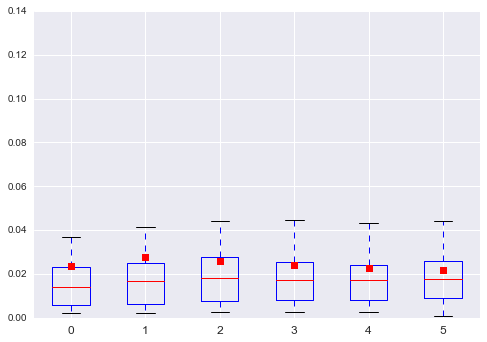

In [327]:
np.abs(t20_lbci-t20_ubci).boxplot(showmeans=True)

In [317]:
lb0 = [0.797483,0.547942,0.377321,0.254712,0.161512,0.097901]
ub0 = [0.783915,0.523506,0.350439,0.229619,0.140657,0.082084]
ub1=[0.805384,0.735663,0.663009,0.591353,0.521691,0.456545]
lb1 =[0.786132,0.710846,0.633239,0.557625,0.485092,0.418233]

In [344]:
pred_survfcn.head()

,0,1,2,3,4,5
0,0.790794,0.535808,0.363877,0.242069,0.150915,0.089789
1,0.795955,0.723477,0.648348,0.574688,0.503543,0.437477
2,0.813476,0.790346,0.763374,0.736620,0.708404,0.678051
3,0.831739,0.813772,0.794459,0.778485,0.761787,0.744483
4,0.061212,0.046775,0.035034,0.026612,0.020436,0.015981


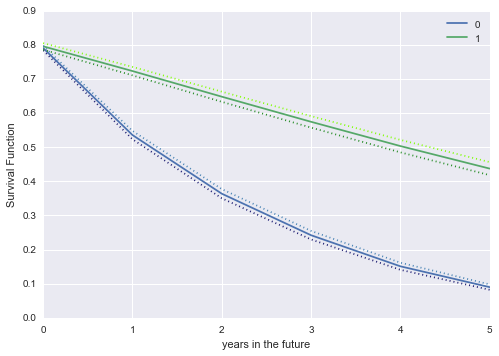

In [318]:
pred_survfcn.T.ix[:,:1].plot()
plt.plot(np.arange(0,6),lb0,ls=':',color='steelblue')
plt.plot(np.arange(0,6),ub0,ls=':',color='midnightblue')
plt.plot(np.arange(0,6),lb1,ls=':',color='forestgreen')
plt.plot(np.arange(0,6),ub1,ls=':',color='chartreuse')

plt.xlabel('years in the future')
plt.ylabel('Survival Function')

In [319]:
s_cf4.print_summary()

n=76368, number of events=31927

                       coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
Age_years        -9.386e-01  3.912e-01 1.023e-02 -9.175e+01  0.000e+00  -9.587e-01  -9.185e-01  ***
SAL1             -1.115e+00  3.278e-01 1.479e-02 -7.539e+01  0.000e+00  -1.144e+00  -1.086e+00  ***
MERIT1            2.742e-01  1.315e+00 6.343e-03  4.323e+01  0.000e+00   2.618e-01   2.866e-01  ***
PERF1            -1.016e-01  9.034e-01 1.240e-02 -8.195e+00  2.514e-16  -1.259e-01  -7.730e-02  ***
BOX1             -4.839e-01  6.164e-01 6.824e-03 -7.090e+01  0.000e+00  -4.972e-01  -4.705e-01  ***
SEX               1.643e-01  1.179e+00 6.098e-03  2.695e+01 5.826e-160   1.524e-01   1.763e-01  ***
HAVE_INS         -3.066e-01  7.359e-01 9.072e-03 -3.380e+01 1.975e-250  -3.244e-01  -2.888e-01  ***
HAVE_DEP         -2.326e-01  7.925e-01 1.147e-02 -2.027e+01  2.258e-91  -2.550e-01  -2.101e-01  ***
DEPTCNT1         -3.471e-01  7.068e-01 9.569e-03 -3.627e+01 4.495e-

In [349]:
mySF = pd.Panel(data={'sf': pred_survfcn,'lb': t20_lbci,'ub':t20_ubci})

In [351]:
mySF

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 20 (major_axis) x 6 (minor_axis)
Items axis: lb to ub
Major_axis axis: 25915 to 85838
Minor_axis axis: 0 to 5

In [354]:
mySF['ub']

,0,1,2,3,4,5
25915,0.783915,0.523506,0.350439,0.229619,0.140657,0.082084
129486,0.786132,0.710846,0.633239,0.557625,0.485092,0.418233
14289,0.816290,0.793462,0.766829,0.740396,0.712499,0.682471
29041,0.834927,0.817262,0.798265,0.782544,0.766104,0.749059
48029,0.046990,0.035005,0.025511,0.018881,0.014141,0.010804
59412,0.892319,0.882919,0.872968,0.861099,0.850177,0.840851
65674,0.591772,0.493902,0.405311,0.326732,0.259108,0.204850
65872,0.698501,0.662413,0.627695,0.592661,0.554092,0.513470
70843,0.968690,0.964486,0.959873,0.954999,0.949468,0.943562
46577,0.902417,0.890511,0.877209,0.863596,0.851689,0.839731


In [362]:
(1-mySF['sf']).sum(axis=0), (1-mySF['lb']).sum(axis=0), (1-mySF['ub']).sum(axis=0)

(0    4.760148
 1    6.277503
 2    7.230499
 3    7.978295
 4    8.618387
 5    9.187079
 dtype: float64, 0    4.631450
 1    6.112631
 2    7.089257
 3    7.863202
 4    8.525624
 5    9.115235
 dtype: float64, 0    4.901753
 1    6.441058
 2    7.363946
 3    8.085004
 4    8.703144
 5    9.251665
 dtype: float64)

## evaluate for hold out set

In [363]:
ne2e_sf = calculate_specific_survival_function(s_cf4, ne2e)

In [394]:
def predict_partial_hazard_ci(mdl,X):
    """
        X: a (n,d) covariate numpy array or DataFrame. If a DataFrame, columns
            can be in any order. If a numpy array, columns must be in the
            same order as the training data.        
        If covariates were normalized during fitting, they are normalized
        in the same way here.
        If X is a dataframe, the order of the columns do not matter. But
        if X is an array, then the column ordering is assumed to be the
        same as the training dataset.
        Returns the partial hazard for the individuals, partial since the
        baseline hazard is not included. Equal to \exp{\beta X}
    """
    #index = _get_index(X)

    if isinstance(X, pd.DataFrame):
        order = mdl.hazards_.columns
        X = X[order]
    
    index = X.index
    
    if mdl.normalize:
        X = lifelines.utils.normalize(X,mdl._norm_mean.values, mdl._norm_std.values)
    
    df = pd.DataFrame(np.exp(np.dot(X,mdl.confidence_intervals_.T)),index=index)
    df.rename(columns = {0: 'lowerbound',1: 'upperbound'}, inplace=True)#columns.names = ['upperbound','lowerbound']
    
    return df

In [547]:
from scipy import interpolate

def identify_forecast_timepoints(mdl, df, time_col, time_range ):
    column_names = ['time_point_'+np.str(tp) for tp in time_range]
    
    my_index = df.index.tolist()
    relevant_time_points = pd.DataFrame(columns=column_names, index=my_index)
    for idx in my_index:
        my_times = np.array([df.loc[idx,time_col]+tp for tp in time_range])
        relevant_time_points.ix[idx] = my_times
        
    return relevant_time_points

def return_desired_cumulative_hazards(mdl,t):
    """
    t: an event time that is used as the base line to forecast forward in time
    """
    #mdl = s_cf4
    maxtimepoint = mdl.baseline_hazard_.index.max()
    #except IndexError:
    if t > maxtimepoint:
        t = maxtimepoint # just set to the max value.
    try: 
        spec_hazard = mdl.baseline_hazard_.ix[t].values
        c_haz = mdl.baseline_cumulative_hazard_.ix[t].values[0]
        #print spec_hazard, c_haz
    except KeyError:
        #t_1 = s_cf4.baseline_cumulative_hazard_
        t_post = mdl.baseline_hazard_.ix[t:].index[0] # get the first after this point
        t_prior = mdl.baseline_hazard_.ix[:t].index[-1] # get the last before this point
        x = [t_prior, t_post]
        y = [mdl.baseline_cumulative_hazard_.ix[t_prior].values[0],mdl.baseline_cumulative_hazard_.ix[t_post].values[0]]
        #print x, y
        chaz_interp = interpolate.interp1d([t_prior,t_post],y)
        c_haz = chaz_interp(t)
    
    return c_haz



def forecast_survival_function(mdl,df,time_col,time_range=[0,1,2,3,4,5],show_ci=True):
    
    #def calculate_specific_survival_function(mdl, df):
    # calculate the predicted hazard
    my_partial_hazard = mdl.predict_partial_hazard(df)
    # asign the specific timepoints and calculate the cumulative hazards at these points
    forecast_times = identify_forecast_timepoints(mdl, df, time_col, time_range)
    specific_cumulative_hazards =  forecast_times.applymap(lambda x: return_desired_cumulative_hazards(mdl,x))
    # predict the survival function at these forecasted times
    
    pred_survival_fcn = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values,
                                                         my_partial_hazard.values)),index=df.index)
    
    if show_ci:
        #def calculate_specific_survival_function_ci(mdl, df):
        # calculate the predicted hazard
        partial_hazard_ci = predict_partial_hazard_ci(mdl,df)
        pred_lower_survival_ci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values.T,
                                                                  partial_hazard_ci.values[:,0])),columns=df.index).T
        pred_upper_survival_ci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values.T,
                                                                  partial_hazard_ci.values[:,1])),columns=df.index).T
        surv_prediction = pd.Panel(data={'surv':pred_survival_fcn, 'lbci':pred_lower_survival_ci,
                                         'ubci':pred_upper_survival_ci})
    else:
        surv_prediction = pd.Panel(data={'surv':pred_survival_fcn, 'lbci':pred_survival_fcn,
                                         'ubci':pred_survival_fcn})
        
    return surv_prediction
    

In [380]:
pred_20 = forecast_survival_function(s_cf4,take20,'Tenure_years')

In [381]:
pred_20

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 20 (major_axis) x 6 (minor_axis)
Items axis: lbci to ubci
Major_axis axis: 25915 to 85838
Minor_axis axis: 0 to 5

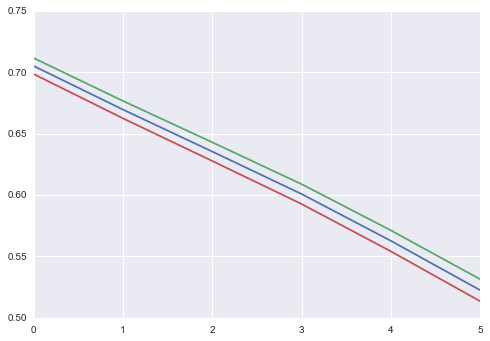

In [397]:
pred_20['surv'].ix[65872].plot()
pred_20['lbci'].ix[65872].plot()
pred_20['ubci'].ix[65872].plot()

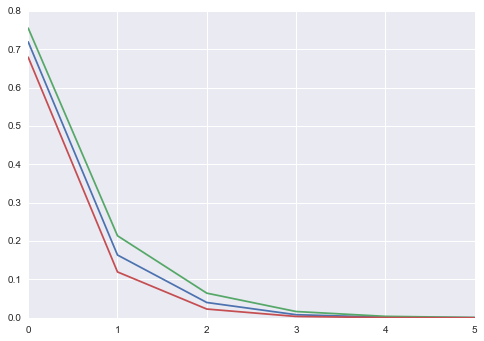

In [391]:
pred_20['surv'].ix[86363].plot()
pred_20['lbci'].ix[86363].plot()
pred_20['ubci'].ix[86363].plot()

In [399]:
(1-pred_20['surv']).sum(axis=0)

0    4.760148
1    6.277503
2    7.230499
3    7.978295
4    8.618387
5    9.187079
dtype: float64

In [400]:
ne2e_pred = forecast_survival_function(s_cf4,ne2e,'Tenure_years')

In [401]:
ne2e_pred

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 23866 (major_axis) x 6 (minor_axis)
Items axis: lbci to ubci
Major_axis axis: 25915 to 90507
Minor_axis axis: 0 to 5

In [402]:
(1-ne2e_pred['surv']).sum(axis=0)

0     6015.204421
1     7703.050789
2     8792.231214
3     9670.360110
4    10423.701529
5    11087.701520
dtype: float64

In [404]:
for frame in ne2e_pred.items:
    print frame, (1-ne2e_pred[frame]).sum(axis=0)

lbci 0     6199.227522
1     7902.991716
2     8966.678506
3     9815.634023
4    10540.151091
5    11176.887459
dtype: float64
surv 0     6015.204421
1     7703.050789
2     8792.231214
3     9670.360110
4    10423.701529
5    11087.701520
dtype: float64
ubci 0     5839.181113
1     7502.170237
2     8612.200555
3     9517.758816
4    10299.588007
5    10991.316645
dtype: float64


In [636]:
ne2e_pred['surv'].head()

,0,1,2,3,4,5
25915,0.790794,0.535808,0.363877,0.242069,0.150915,0.089789
129486,0.795955,0.723477,0.648348,0.574688,0.503543,0.437477
14289,0.813476,0.790346,0.763374,0.736620,0.708404,0.678051
29041,0.831739,0.813772,0.794459,0.778485,0.761787,0.744483
48029,0.061212,0.046775,0.035034,0.026612,0.020436,0.015981


In [641]:
ne2e_tmp.head()

,Tenure_years,Age_years,terminated,within5yr_sep,p5_0,p5_1,p5_2,p5_3,p5_4,p5_5
25915,0.662573,25.859532,1,1,0,0,1,1,1,1
129486,2.576370,29.364053,0,0,0,0,0,0,0,1
14289,11.551230,55.486423,0,0,0,0,0,0,0,0
29041,17.122870,59.831482,0,0,0,0,0,0,0,0
48029,25.555624,44.469086,0,0,1,1,1,1,1,1


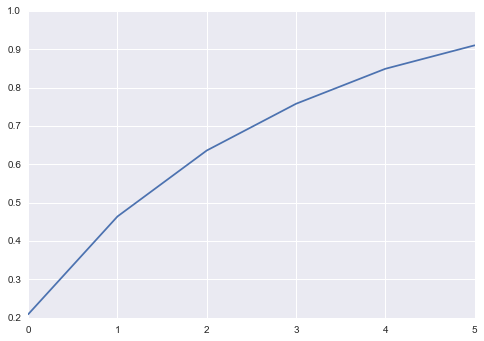

In [640]:
(1-ne2e_pred['surv']).ix[25915].plot()

## Now work on evaluation
* inspired by correspondence to the evaluation set

In [445]:
ne2e_totals = pd.DataFrame((1-ne2e_pred['surv']).sum(axis=0),columns=['surv_sum'])
ne2e_totals.diff()/len(ne2e)

,surv_sum
0,NaN
1,0.070722
2,0.045637
3,0.036794
4,0.031565
5,0.027822


In [406]:
ne2e.terminated.sum() # total number terminated

9942L

In [413]:
len(ne2eval[(ne2eval['term_tstmp']>'2009-12-31')&(ne2eval.terminated==1)]), len(ne2eval)

(3484, 23866)

In [411]:
return_concordance(ne2e[sep_cols],s_cf4,'Tenure_years','terminated')

0.88715965871132707

In [414]:
recent_term_idx = ne2eval[(ne2eval['term_tstmp']>'2009-12-31')&(ne2eval.terminated==1)].index
(1-ne2e_pred['surv'].ix[recent_term_idx]).sum(axis=0)

0    1013.607526
1    1434.155897
2    1685.065815
3    1878.560045
4    2038.363249
5    2173.513065
dtype: float64

In [416]:
true_term_idx = ne2e[ne2e.terminated==1].index
(1-ne2e_pred['surv'].ix[true_term_idx]).sum(axis=0)

0    4026.786163
1    5159.128987
2    5835.769443
3    6346.909699
4    6759.967553
5    7103.472448
dtype: float64

In [433]:
#ne2e_pred['surv'].mask(ne2e_pred['surv'].ix[true_term_idx])
#ne2e_pred['surv'].loc[list(set(true_term_idx),5]
true_notterm_idx = list(set(ne2e.index)-set(true_term_idx))
(1-ne2e_pred['surv'].loc[true_notterm_idx]).sum(axis=0)

0    1988.418259
1    2543.921802
2    2956.461772
3    3323.450411
4    3663.733977
5    3984.229073
dtype: float64

In [657]:
s_cf4.print_summary()

n=76368, number of events=31927

                       coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
Age_years        -9.386e-01  3.912e-01 1.023e-02 -9.175e+01  0.000e+00  -9.587e-01  -9.185e-01  ***
SAL1             -1.115e+00  3.278e-01 1.479e-02 -7.539e+01  0.000e+00  -1.144e+00  -1.086e+00  ***
MERIT1            2.742e-01  1.315e+00 6.343e-03  4.323e+01  0.000e+00   2.618e-01   2.866e-01  ***
PERF1            -1.016e-01  9.034e-01 1.240e-02 -8.195e+00  2.514e-16  -1.259e-01  -7.730e-02  ***
BOX1             -4.839e-01  6.164e-01 6.824e-03 -7.090e+01  0.000e+00  -4.972e-01  -4.705e-01  ***
SEX               1.643e-01  1.179e+00 6.098e-03  2.695e+01 5.826e-160   1.524e-01   1.763e-01  ***
HAVE_INS         -3.066e-01  7.359e-01 9.072e-03 -3.380e+01 1.975e-250  -3.244e-01  -2.888e-01  ***
HAVE_DEP         -2.326e-01  7.925e-01 1.147e-02 -2.027e+01  2.258e-91  -2.550e-01  -2.101e-01  ***
DEPTCNT1         -3.471e-01  7.068e-01 9.569e-03 -3.627e+01 4.495e-

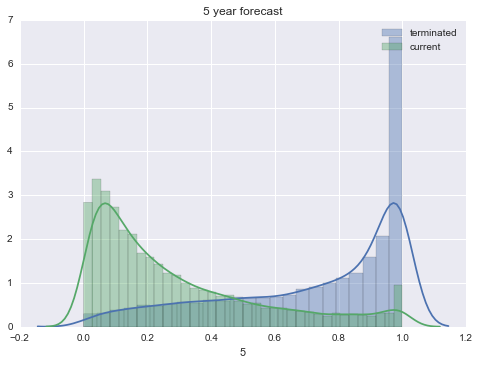

In [440]:
sns.distplot(1-ne2e_pred['surv'].loc[true_term_idx,5],label='terminated')
#sns.distplot(1-ne2e_pred['surv'].loc[recent_term_idx,5],label='recent_term')
sns.distplot(1-ne2e_pred['surv'].loc[true_notterm_idx,5],label='current')
plt.legend()
plt.title('5 year forecast')

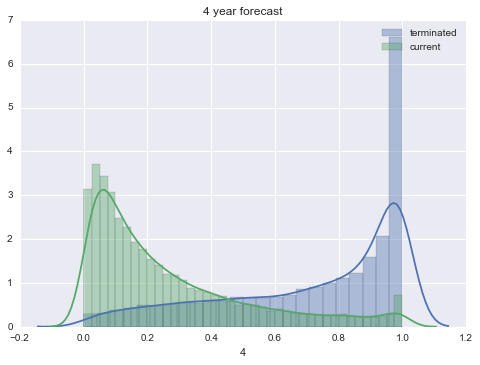

In [449]:

sns.distplot(1-ne2e_pred['surv'].loc[true_term_idx,5],label='terminated')
#sns.distplot(1-ne2e_pred['surv'].loc[recent_term_idx,4],label='recent_term')
sns.distplot(1-ne2e_pred['surv'].loc[true_notterm_idx,4],label='current')
plt.legend()
plt.title('4 year forecast')

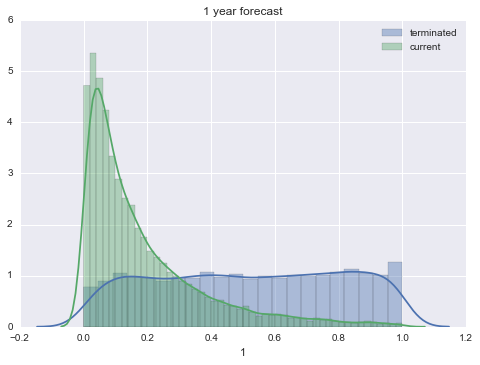

In [643]:
sns.distplot(1-ne2e_pred['surv'].loc[true_term_idx,1],label='terminated')
sns.distplot(1-ne2e_pred['surv'].loc[true_notterm_idx,1],label='current')
plt.legend()
plt.title('1 year forecast')

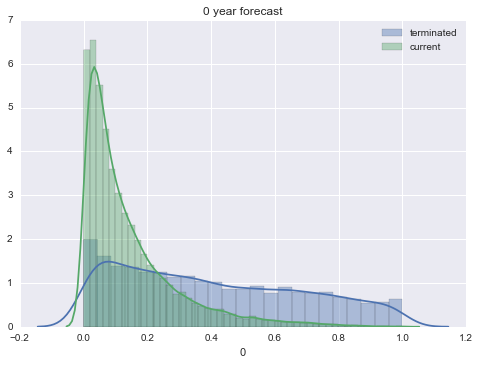

In [435]:
sns.distplot(1-ne2e_pred['surv'].loc[true_term_idx,0],label='terminated')
sns.distplot(1-ne2e_pred['surv'].loc[true_notterm_idx,0],label='current')
plt.legend()
plt.title('0 year forecast')

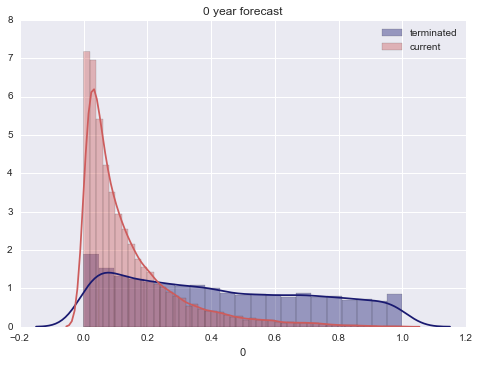

In [436]:
sns.distplot(1-ne2e_pred['lbci'].loc[true_term_idx,0],label='terminated',color='midnightblue')
sns.distplot(1-ne2e_pred['lbci'].loc[true_notterm_idx,0],label='current',color='indianred')
plt.legend()
plt.title('0 year forecast')

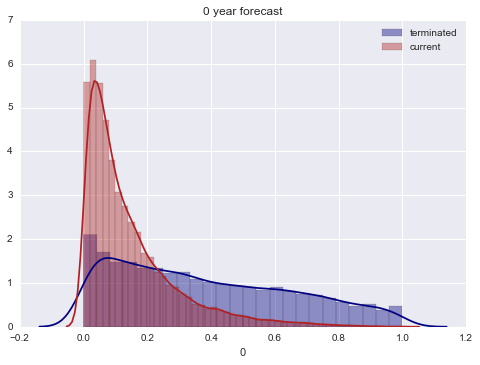

In [447]:
sns.distplot(1-ne2e_pred['ubci'].loc[true_term_idx,0],label='terminated',color='navy')
sns.distplot(1-ne2e_pred['ubci'].loc[true_notterm_idx,0],label='current',color='firebrick')
plt.legend()
plt.title('0 year forecast')

In [ ]:
## if I do the sums based upon a threshold cutoff
* looking at the above

In [482]:
def find_max_score_value(y_true, y_pred, metric_name, showplot=True,  **kwargs):
    """
    y_true
    y_pred
    metric_name -->> a sklearn metric name
    
    A poor-man's grid search over the evaluation metrics to identify 
    the best offset values (i.e. point where desired metric score is 
    highest)
    """
    scores = []
    offsets = []
    # stage 1: Note if the metric is outside of [0,1] this will not work.
    for offset in np.arange(0,10)/float(10):
        score = metric_name(y_true,map(np.int,y_pred+offset))
        scores.append(score)
        offsets.append(offset)
    # find the max
    mxscore = max(scores)
    mx_idx = scores.index(mxscore)
    #now offset below and above
    if mx_idx == 0:
        for offset in np.arange(0,16)/float(100):
            offset+=0.0
            score = metric_name(y_true,map(np.int,y_pred+offset))
            scores.append(score)
            offsets.append(offset)
    elif mx_idx == 9:
        for offset in np.arange(0,21)/float(100):
            offset+=0.8
            score = metric_name(y_true,map(np.int,y_pred+offset))
            scores.append(score)
            offsets.append(offset)
    else:
        base_offset = offsets[mx_idx-1]
        for offset in np.arange(0,21)/float(100):
            offset+=base_offset
            score = metric_name(y_true,map(np.int,y_pred+offset))
            scores.append(score)
            offsets.append(offset)
    
    if showplot:             
        plt.plot(offsets,scores,'d',color='indigo')
        plt.xlabel('offset value')
        plt.ylabel(metric_name)
    
    mxmxscore = max(scores)
    mxmx_idx = scores.index(mxmxscore)
    print mxmxscore, offsets[mxmx_idx]
    #if verbose:
    #    print "__________"
    #    print scores
    #return mcc_scores, mcc_offsets
    return offsets[mxmx_idx]

In [474]:
metrics.f1_score(ne2e.terminated.values,map(np.int,1-ne2e_pred['surv'].loc[:,2].values+0.5))

0.69306592216967688

In [492]:
f1_off = []
for i in np.arange(0,6):
    f1_off.append(find_max_score_value(ne2e.terminated.values,1-ne2e_pred['surv'].loc[:,i],metrics.f1_score,showplot=False))

0.683107038334 0.82
0.72497355515 0.74
0.735572697979 0.67
0.741016693389 0.66
0.746689368142 0.61
0.749205125735 0.54


In [605]:
f1_off_in5 = []
for i in np.arange(0,6):
    f1_off_in5.append(find_max_score_value(ne2e_tmp.within5yr_sep.values,1-ne2e_pred['surv'].loc[:,i],metrics.f1_score,showplot=False))

0.270035905426 0.83
0.304710867398 0.8
0.314269985932 0.77
0.320269200317 0.68
0.324203223242 0.56
0.328138404347 0.52


In [606]:
metrics.confusion_matrix(ne2e_tmp.terminated.values,map(np.int,1-ne2e_pred['surv'].loc[:,1]+0.52))

array([[12745,  1179],
       [ 4571,  5371]])

In [498]:
#### what if I annualize the overall departures?
nterm = 9942
nterm/5

1988

In [644]:
len(ne2e)

23866

In [502]:
((1-ne2e_pred['surv'])+f1_off).head()

,0,1,2,3,4,5
25915,1.029206,1.204192,1.306123,1.417931,1.459085,1.450211
129486,1.024045,1.016523,1.021652,1.085312,1.106457,1.102523
14289,1.006524,0.949654,0.906626,0.923380,0.901596,0.861949
29041,0.988261,0.926228,0.875541,0.881515,0.848213,0.795517
48029,1.758788,1.693225,1.634966,1.633388,1.589564,1.524019


In [506]:
((1-ne2e_pred['surv'])>=0.5).astype(int).sum(axis=0)

0     4195
1     6262
2     7609
3     8616
4     9473
5    10201
dtype: int64

In [579]:
## find the examples where there was a recent separation
ne2e_tmp = ne2e[['Tenure_years','Age_years','terminated']].copy()
ne2e_tmp['within5yr_sep']=0
ne2e_tmp['within5yr_sep'].ix[recent_term_idx]=1
ne2e_tmp.within5yr_sep.sum()

3484L

In [580]:
tmp_cols = ['p5_'+np.str(year) for year in [0,1,2,3,4,5]]
#column_names = ['time_point_'+np.str(year) for year in yr_range]
tdf = ((1-ne2e_pred['surv'])>=0.5).astype(int)
tdf.columns=tmp_cols
tdf.head()

,p5_0,p5_1,p5_2,p5_3,p5_4,p5_5
25915,0,0,1,1,1,1
129486,0,0,0,0,0,1
14289,0,0,0,0,0,0
29041,0,0,0,0,0,0
48029,1,1,1,1,1,1


In [581]:
ne2e_tmp=pd.concat([ne2e_tmp,tdf],axis=1)
ne2e_tmp

,Tenure_years,Age_years,terminated,within5yr_sep,p5_0,p5_1,p5_2,p5_3,p5_4,p5_5
25915,0.662573,25.859532,1,1,0,0,1,1,1,1
129486,2.576370,29.364053,0,0,0,0,0,0,0,1
14289,11.551230,55.486423,0,0,0,0,0,0,0,0
29041,17.122870,59.831482,0,0,0,0,0,0,0,0
48029,25.555624,44.469086,0,0,1,1,1,1,1,1
59412,24.309876,45.312361,0,0,0,0,0,0,0,0
65674,3.545590,27.452994,1,0,0,0,1,1,1,1
65872,12.681985,42.823603,0,0,0,0,0,0,0,0
70843,13.289801,56.310533,0,0,0,0,0,0,0,0
46577,15.627973,36.310123,0,0,0,0,0,0,0,0


0.041966662949


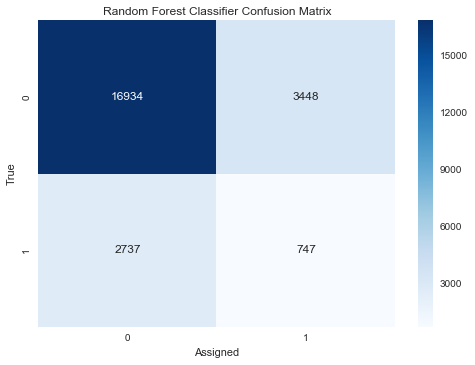

In [582]:
plot_conf_matrix(ne2e_tmp.within5yr_sep,ne2e_tmp.p5_0,normed=False)

0.496785013607


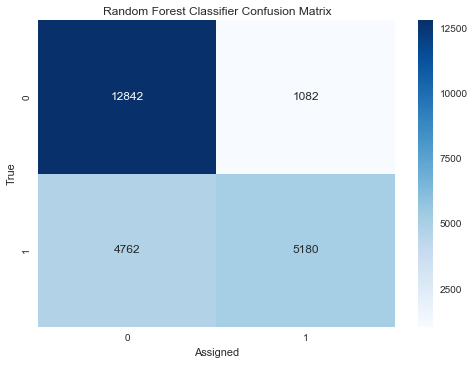

In [645]:
plot_conf_matrix(ne2e_tmp.terminated,ne2e_tmp.p5_1,normed=False)

In [590]:
ne2e_tmp[cola]

,p5_0,p5_1,p5_2,p5_3,p5_4,p5_5
25915,0,0,1,1,1,1
129486,0,0,0,0,0,1
14289,0,0,0,0,0,0
29041,0,0,0,0,0,0
48029,1,1,1,1,1,1
59412,0,0,0,0,0,0
65674,0,0,1,1,1,1
65872,0,0,0,0,0,0
70843,0,0,0,0,0,0
46577,0,0,0,0,0,0


In [593]:
ne2e_pred['surv'].head()

,0,1,2,3,4,5
25915,0.790794,0.535808,0.363877,0.242069,0.150915,0.089789
129486,0.795955,0.723477,0.648348,0.574688,0.503543,0.437477
14289,0.813476,0.790346,0.763374,0.736620,0.708404,0.678051
29041,0.831739,0.813772,0.794459,0.778485,0.761787,0.744483
48029,0.061212,0.046775,0.035034,0.026612,0.020436,0.015981


In [595]:
for cola in  tmp_cols:
    print cola," : ", metrics.f1_score(ne2e_tmp.terminated, ne2e_tmp[cola]), "\t", metrics.f1_score(ne2e_tmp.within5yr_sep, ne2e_tmp[cola])
        

 p5_0  :  0.514536323124 	0.194556582888
p5_1  :  0.639348309059 	0.258567617484
p5_2  :  0.69306592217 	0.290453439106
p5_3  :  0.719150770557 	0.308760330579
p5_4  :  0.734895699202 	0.319209693602
p5_5  :  0.744576279601 	0.327073438071


In [609]:
for cola in  tmp_cols:
    colb = np.int(cola[-1])
    #print cola," : ", metrics.hamming_loss(ne2e_tmp.terminated, ne2e_tmp[cola]), "\t", metrics.roc_auc_score(ne2e_tmp.terminated, ne2e_tmp[cola])
    print cola," : ", metrics.roc_auc_score(ne2e_tmp.terminated,((1-ne2e_pred['surv'][colb])+.54).astype(int)), "\t", metrics.roc_auc_score(ne2e_tmp.terminated, ne2e_tmp[cola])    

p5_0  :  0.67605183896 	0.662873537532
p5_1  :  0.734168251989 	0.721657185939
p5_2  :  0.759119598642 	0.751040688391
p5_3  :  0.772517487379 	0.765824842114
p5_4  :  0.778486024746 	0.77478926033
p5_5  :  0.78190416221 	0.780110680441


In [607]:
for cola in  tmp_cols:
    colb = np.int(cola[-1])
    #print cola," : ", metrics.hamming_loss(ne2e_tmp.terminated, ne2e_tmp[cola]), "\t", metrics.roc_auc_score(ne2e_tmp.terminated, ne2e_tmp[cola])
    print cola," : ", metrics.brier_score_loss(ne2e_tmp.terminated, (1-ne2e_pred['surv'][colb])), "\t", metrics.matthews_corrcoef(ne2e_tmp.terminated, ne2e_tmp[cola])    

p5_0  :  0.20646697386 	0.421910379554
p5_1  :  0.171523623039 	0.496785013607
p5_2  :  0.160642482697 	0.531139994323
p5_3  :  0.156251663142 	0.54570342554
p5_4  :  0.155385738471 	0.55376972146
p5_5  :  0.156782539719 	0.558280371839


In [510]:
((1-ne2e_pred['lbci'])>=0.5).astype(int).sum(axis=0)

0     4528
1     6585
2     7881
3     8835
4     9631
5    10314
dtype: int64

In [511]:
((1-ne2e_pred['ubci'])>=0.5).astype(int).sum(axis=0)

0     3868
1     5906
2     7306
3     8384
4     9299
5    10072
dtype: int64

In [509]:
for i in np.arange(0,6):
    y_true = ne2e.terminated.values
    y_50pred = ((1-ne2e_pred['surv'].loc[:,i])>=0.5).astype(int)
    print i, metrics.f1_score(y_true,y_50pred), metrics.matthews_corrcoef(y_true,y_50pred) #print metrics.confusion_matrix(,)

0 0.514536323124 0.421910379554
1 0.639348309059 0.496785013607
2 0.69306592217 0.531139994323
3 0.719150770557 0.54570342554
4 0.734895699202 0.55376972146
5 0.744576279601 0.558280371839


[[11222  2702]
 [ 2443  7499]]
0.558280371839


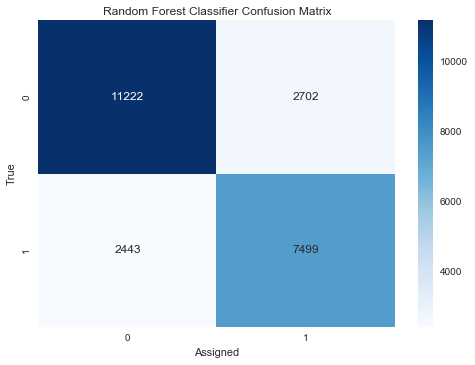

In [655]:
print metrics.confusion_matrix(y_true,((1-ne2e_pred['surv'].loc[:,5])>=0.5).astype(int))
plot_conf_matrix(y_true,((1-ne2e_pred['surv'].loc[:,5])>=0.5).astype(int),normed=False)

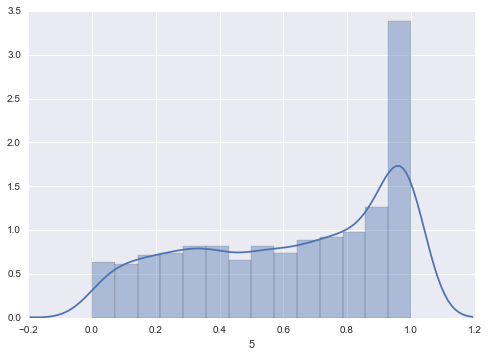

In [616]:
#sns.distplot((1-ne2e_pred['surv'].loc[recent_term_idx,0]))
#sns.distplot((1-ne2e_pred['surv'].loc[recent_term_idx,0]))
sns.distplot(1-ne2e_pred['surv'].loc[recent_term_idx,5],label='terminated')
#sns.distplot(1-ne2e_pred['surv'].loc[true_notterm_idx,0],label='not_terminated')

## So let me try this on the 'current' employees

In [517]:
current = empl1[empl1.status == 0].copy()
len(current)

69475

In [524]:
curr = pipe.fit(ne2build[modeling_cols],ne2build.terminated).transform(current[modeling_cols])

In [526]:
curr.shape

(69475, 123)

In [527]:
curr.head()

,ADDRCNT1,Age_years,BOX1,COMPANY,COMP_FREQUENCY,CUR_DEPT_MOS,CUR_EFUNC_MOS,CUR_FUNC_MOS,CUR_GRADE_MOS,CUR_JOB_MOS,...,loc_desc_MRSF,loc_desc_VAC,loc_desc_MC,loc_desc_EST,loc_desc_CAT,loc_desc_ESP,loc_desc_AO,loc_desc_SIU,MERIT1_d,PERF1_d
1,1,21.322820,0,1,1,6.709677,6.709677,6.709677,6.709677,6.709677,...,0,0,0,0,0,0,0,0,1,1
2,0,26.853392,2,1,0,10.967742,10.967742,10.967742,10.967742,10.967742,...,0,0,0,0,0,0,0,0,0,0
4,0,23.723964,2,1,0,18.225807,18.225807,18.225807,18.225807,18.225807,...,0,0,0,0,0,0,0,0,0,0
7,0,57.638418,2,5,0,3.709677,3.709677,3.709677,106.645161,106.645161,...,0,0,0,0,0,0,0,0,0,0
8,0,46.993436,2,5,0,3.064516,3.064516,173.290323,139.225806,3.064516,...,0,0,0,0,0,0,0,0,0,0


In [551]:
curr_surv_pred = forecast_survival_function(s_cf4,curr,'Tenure_years')

In [556]:
#return_concordance(curr[sep_cols],s_cf4,'Tenure_years','terminated')
#np.shape(curr[sep_cols])

In [560]:
curr_p5 = pd.DataFrame(((1-curr_surv_pred['surv'])>=0.5).astype(int).sum(axis=0),columns=['surv'])
curr_p5

,surv
0,2651
1,5273
2,7431
3,9415
4,11363
5,13228


In [652]:
len(curr)

69475

In [561]:
curr_p5['lower'] = ((1-curr_surv_pred['ubci'])>=0.5).astype(int).sum(axis=0)
curr_p5['upper']= ((1-curr_surv_pred['lbci'])>=0.5).astype(int).sum(axis=0)
curr_p5

,surv,lower,upper
0,2651,2496,2843
1,5273,4953,5562
2,7431,7185,7686
3,9415,9201,9630
4,11363,11200,11578
5,13228,13160,13354


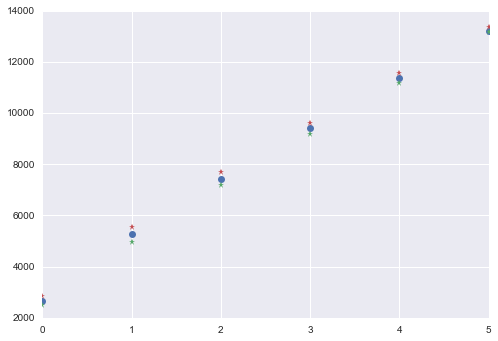

In [564]:
plt.plot(curr_p5.surv,'o')
plt.plot(curr_p5.lower,'*')
plt.plot(curr_p5.upper,'*')

In [566]:
def plot_conf_matrix(y_true, y_pred, normed=True, heatmap_color ='Blues', **kwargs):
    ## check to make sure that y_pred is an array of integers if y_true is a bunch of integers
    true_int_check = all(isinstance(a,int) for a in y_true)
    pred_int_check = all(isinstance(a,int) for a in y_pred)
    if true_int_check and not pred_int_check: # convert the y_pred values to integers
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.astype(int)

    my_c = metrics.confusion_matrix(y_true, y_pred)

    print metrics.matthews_corrcoef(y_true, y_pred)
    if normed:
        cm_normalized = my_c.astype('float') / my_c.sum(axis=1)[:, np.newaxis]
        my_c = cm_normalized
        plt.title('Normalized RF Classifier Confusion Matrix')
    else:
        plt.title('Random Forest Classifier Confusion Matrix')

    sns.heatmap(my_c, annot=True,  fmt='',cmap=heatmap_color, **kwargs)
    plt.ylabel('True')
    plt.xlabel('Assigned')
    plt.show()

    return


### Set up a dictionary for some of these 'interesting' jobs
#### December 31, 2015

* The extended Functions (EXT_FUNC_ID_SFI) Jeff Briks is interested in are:
    * CCC Sales (00892)
    * CCC Service (00071)
    * Life Health Response Center (00816)
    * Enterprise Auto Express (00909)
    * Enterprise ILR (00910)
    * State Farm Bank (00517)
    * SFPP (00835)
* The jobs (JOBCODES) he is interested in are these:
    * CCC Service Rep (6200)
    * CCC Sales Rep (1876)
    * Life Customer Service Asst (2638, 2639, & 2641)
    * Claim Associate-Express (0983 & 0984)
    * Claim Associate-ILR (1009)
    * Claim Team Manager – ILR (0986)
    * Bank Customer Service Rep (0851, 852, & 0853)
    * SFPP Account Rep (4105)

In [617]:
#interesting_extended_functions = [892,71, 816, 909,910,517,835]
extFuncDict ={}
extFuncDict[892]='CCC Sales'
extFuncDict[71]='CCC Service'
extFuncDict[816]='Life Health Response Center'
#(00816)
extFuncDict[909]='Enterprise Auto Express'
extFuncDict[910]='Enterprise ILR' 
extFuncDict[517]='State Farm Bank'
extFuncDict[835]='SFPP'
interesting_extended_functions = extFuncDict.keys()
print "extended Functions:", extFuncDict

jobCodeDict = {}
jobCodeDict[6200]= 'CCC Service Rep'
jobCodeDict[1876]= 'CCC Sales Rep'
jobCodeDict[1009]='CLaim Associate-ILR'
jobCodeDict[986]='CLaim Team Manager-ILR'
jobCodeDict[983]='Claim Associate-Express'
jobCodeDict[984]='Claim Associate-Express'
jobCodeDict[2638]='Life Customer Service Asst'
jobCodeDict[2639]='Life Customer Service Asst'
jobCodeDict[2641]='Life Customer Service Asst'
jobCodeDict[4105]= 'SFPP Account Rep'
jobCodeDict[851]= 'Bank Customer Service Rep'
jobCodeDict[852]= 'Bank Customer Service Rep'
jobCodeDict[853]= 'Bank Customer Service Rep'
interesting_jobcodes =  jobCodeDict.keys()
jobCodeDict

extended Functions: {835: 'SFPP', 517: 'State Farm Bank', 71: 'CCC Service', 909: 'Enterprise Auto Express', 910: 'Enterprise ILR', 816: 'Life Health Response Center', 892: 'CCC Sales'}


{851: 'Bank Customer Service Rep',
 852: 'Bank Customer Service Rep',
 853: 'Bank Customer Service Rep',
 983: 'Claim Associate-Express',
 984: 'Claim Associate-Express',
 986: 'CLaim Team Manager-ILR',
 1009: 'CLaim Associate-ILR',
 1876: 'CCC Sales Rep',
 2638: 'Life Customer Service Asst',
 2639: 'Life Customer Service Asst',
 2641: 'Life Customer Service Asst',
 4105: 'SFPP Account Rep',
 6200: 'CCC Service Rep'}

In [620]:
thresh = 0.5
curr_surv_pred['surv'].applymap(lambda x: 0 if x>thresh else 1).sum() # return the sum of people likely to leave (below threshold)

0     2651
1     5273
2     7431
3     9415
4    11363
5    13228
dtype: int64

### Now check for the specific jobcodes & extended functions

In [622]:
## count how many examples in the current dataframe
[(v,len(curr[curr.EXT_FUNC_ID_SFI==k])) for k,v in extFuncDict.iteritems()]

[('SFPP', 783),
 ('State Farm Bank', 1507),
 ('CCC Service', 1823),
 ('Enterprise Auto Express', 2587),
 ('Enterprise ILR', 2462),
 ('Life Health Response Center', 376),
 ('CCC Sales', 1636)]

In [626]:
invJobCodeDict = {}
invJobCodeDict['CCC Service Rep'] = [6200]
invJobCodeDict['CCC Sales Rep'] = [1876]
invJobCodeDict['Life Customer Service Asst'] = [2638,2639,2641]
invJobCodeDict['Claim Associate-Express'] = [983,984]
invJobCodeDict['Claim Associate-ILR'] = [1009]
invJobCodeDict['Claim Team Manager-ILR'] = [986]
invJobCodeDict['Bank Customer Service Rep'] = [851,852,853]
invJobCodeDict['SFPP Account Rep'] = [4105]#2638,2639,2641]
interest_job_names_list = invJobCodeDict.keys()

In [630]:
thresh = 0.5
for jc_val in invJobCodeDict.keys():
    print "------------"
    print invJobCodeDict[jc_val], jc_val
    print "total current employees is {0}".format(len(curr[curr.JOBCODE.isin(invJobCodeDict[jc_val])]))
    pred_vals = curr_surv_pred['surv'][curr.JOBCODE.isin(invJobCodeDict[jc_val])].applymap(lambda x: 0 if x> thresh else 1).sum()
    for i,v in enumerate(pred_vals):
        print "predicted separation count in {0} years = {1}".format(i,v)

------------
[6200] CCC Service Rep
total current employees is 1472
predicted separation count in 0 years = 248
predicted separation count in 1 years = 710
predicted separation count in 2 years = 886
predicted separation count in 3 years = 1004
predicted separation count in 4 years = 1081
predicted separation count in 5 years = 1126
------------
[1009] Claim Associate-ILR
total current employees is 2012
predicted separation count in 0 years = 36
predicted separation count in 1 years = 569
predicted separation count in 2 years = 929
predicted separation count in 3 years = 1147
predicted separation count in 4 years = 1287
predicted separation count in 5 years = 1382
------------
[986] Claim Team Manager-ILR
total current employees is 209
predicted separation count in 0 years = 5
predicted separation count in 1 years = 5
predicted separation count in 2 years = 6
predicted separation count in 3 years = 10
predicted separation count in 4 years = 14
predicted separation count in 5 years = 16

In [634]:
sum(curr.EXT_FUNC_ID_SFI==835)

783

In [635]:
thresh = 0.5
for jc_val in extFuncDict.keys():
    
    print "------------"
    print extFuncDict[jc_val], jc_val
    print "total current employees is {0}".format(len(curr[curr.EXT_FUNC_ID_SFI==jc_val]))
    pred_vals = curr_surv_pred['surv'][curr.EXT_FUNC_ID_SFI==jc_val].applymap(lambda x: 0 if x> thresh else 1).sum()
    for i,v in enumerate(pred_vals):
        print "predicted separation count in {0} years = {1}".format(i,v)

------------
SFPP 835
total current employees is 783
predicted separation count in 0 years = 92
predicted separation count in 1 years = 227
predicted separation count in 2 years = 299
predicted separation count in 3 years = 362
predicted separation count in 4 years = 414
predicted separation count in 5 years = 457
------------
State Farm Bank 517
total current employees is 1507
predicted separation count in 0 years = 76
predicted separation count in 1 years = 145
predicted separation count in 2 years = 224
predicted separation count in 3 years = 299
predicted separation count in 4 years = 379
predicted separation count in 5 years = 439
------------
CCC Service 71
total current employees is 1823
predicted separation count in 0 years = 288
predicted separation count in 1 years = 778
predicted separation count in 2 years = 974
predicted separation count in 3 years = 1116
predicted separation count in 4 years = 1207
predicted separation count in 5 years = 1271
------------
Enterprise Auto 

In [658]:
thresh = 0.5
for jc_val in extFuncDict.keys():
    
    print "------------"
    print extFuncDict[jc_val], jc_val
    print "total current employees is {0}".format(len(curr[curr.EXT_FUNC_ID_SFI==jc_val]))
    pred_vals = curr_surv_pred['ubci'][curr.EXT_FUNC_ID_SFI==jc_val].applymap(lambda x: 0 if x> thresh else 1).sum()
    for i,v in enumerate(pred_vals):
        print "predicted separation count in {0} years = {1}".format(i,v)

------------
SFPP 835
total current employees is 783
predicted separation count in 0 years = 84
predicted separation count in 1 years = 198
predicted separation count in 2 years = 280
predicted separation count in 3 years = 341
predicted separation count in 4 years = 401
predicted separation count in 5 years = 447
------------
State Farm Bank 517
total current employees is 1507
predicted separation count in 0 years = 72
predicted separation count in 1 years = 128
predicted separation count in 2 years = 211
predicted separation count in 3 years = 285
predicted separation count in 4 years = 361
predicted separation count in 5 years = 428
------------
CCC Service 71
total current employees is 1823
predicted separation count in 0 years = 237
predicted separation count in 1 years = 726
predicted separation count in 2 years = 941
predicted separation count in 3 years = 1081
predicted separation count in 4 years = 1181
predicted separation count in 5 years = 1252
------------
Enterprise Auto 

In [650]:
s_cf4.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
Age_years,-0.938603,0.391174,0.010230,-91.750321,0.000000e+00,-0.958658,-0.918548
SAL1,-1.115258,0.327831,0.014794,-75.385669,0.000000e+00,-1.144260,-1.086256
MERIT1,0.274205,1.315485,0.006343,43.226403,0.000000e+00,0.261769,0.286641
PERF1,-0.101613,0.903379,0.012400,-8.194637,2.513509e-16,-0.125921,-0.077304
BOX1,-0.483857,0.616401,0.006824,-70.901449,0.000000e+00,-0.497236,-0.470479
SEX,0.164341,1.178616,0.006098,26.949219,5.825757e-160,0.152386,0.176296
HAVE_INS,-0.306632,0.735921,0.009072,-33.799965,1.974517e-250,-0.324417,-0.288848
HAVE_DEP,-0.232554,0.792507,0.011472,-20.272302,2.258414e-91,-0.255043,-0.210065
DEPTCNT1,-0.347074,0.706753,0.009569,-36.271862,4.494797e-288,-0.365832,-0.328316
EXTFUNC_CNT,0.095909,1.100659,0.005597,17.134509,8.204327e-66,0.084936,0.106882


In [647]:
thresh = 0.5
for jc_val in extFuncDict.keys():
    
    print "------------"
    print extFuncDict[jc_val], jc_val
    print "total current employees is {0}".format(len(curr[curr.EXT_FUNC_ID_SFI==jc_val]))
    pred_vals = curr_surv_pred['ubci'][curr.EXT_FUNC_ID_SFI==jc_val].applymap(lambda x: 0 if x> thresh else 1).sum()
    for i,v in enumerate(pred_vals):
        print "predicted separation count in {0} years = {1}".format(i,v)

------------
SFPP 835
total current employees is 783
predicted separation count in 0 years = 84
predicted separation count in 1 years = 198
predicted separation count in 2 years = 280
predicted separation count in 3 years = 341
predicted separation count in 4 years = 401
predicted separation count in 5 years = 447
------------
State Farm Bank 517
total current employees is 1507
predicted separation count in 0 years = 72
predicted separation count in 1 years = 128
predicted separation count in 2 years = 211
predicted separation count in 3 years = 285
predicted separation count in 4 years = 361
predicted separation count in 5 years = 428
------------
CCC Service 71
total current employees is 1823
predicted separation count in 0 years = 237
predicted separation count in 1 years = 726
predicted separation count in 2 years = 941
predicted separation count in 3 years = 1081
predicted separation count in 4 years = 1181
predicted separation count in 5 years = 1252
------------
Enterprise Auto 

# March 4, 2016
working on retirement predictions for the current employees

In [2]:
import os

In [3]:
os.chdir('../../../projects/HRattrition/webserverTest/models/')

In [4]:
import pandas as pd

In [5]:
import pickle


In [6]:
ret_mdl = pickle.load(open('retirement_sf2.pkl'))
ret_mdl.print_summary()

n=34767, number of events=11905

                coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
Age_years  3.388e-01  1.403e+00 1.010e-02  3.354e+01 1.192e-246   3.190e-01   3.586e-01  ***
SAL1      -2.439e-01  7.836e-01 1.313e-02 -1.858e+01  4.794e-77  -2.697e-01  -2.182e-01  ***
MERIT1    -2.373e-01  7.888e-01 1.416e-02 -1.675e+01  5.614e-63  -2.650e-01  -2.095e-01  ***
PERF1     -1.240e-01  8.834e-01 1.373e-02 -9.032e+00  1.686e-19  -1.509e-01  -9.708e-02  ***
BOX1      -1.031e-02  9.897e-01 1.254e-02 -8.222e-01  4.110e-01  -3.488e-02   1.427e-02     
SEX        1.697e-01  1.185e+00 1.129e-02  1.503e+01  4.522e-51   1.475e-01   1.918e-01  ***
HAVE_INS  -1.610e-01  8.513e-01 1.126e-02 -1.430e+01  2.206e-46  -1.830e-01  -1.389e-01  ***
HAVE_DEP   4.226e-03  1.004e+00 1.099e-02  3.844e-01  7.007e-01  -1.732e-02   2.578e-02     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.723


In [7]:
ret_mdl.durations.name

'Tenure_years'

## read in the set of current employees

In [8]:
os.chdir('../../reduced/')

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
em2002 = pd.read_csv('after2001_v3.csv',dtype={'KEY':np.str,'EMPL_CLASS':np.str,'EEO1CODE':np.str})
em2002.shape

(134266, 69)

In [12]:
pd.crosstab(em2002.status, em2002.retired)

retired,0,1
status,,
0,69475,0
1,49674,15117


In [21]:
current = em2002[em2002.status==0].copy()

In [22]:
def get_surv_model_columns(surv_mdl):
    event_col = surv_mdl.event_observed.name
    time_col = surv_mdl.durations.name
    model_cols = surv_mdl.hazards_.columns.tolist()
    cols_to_keep = [a for a in model_cols]
    cols_to_keep.append(event_col)
    cols_to_keep.append(time_col)
    return cols_to_keep

ret_cols_to_keep = get_surv_model_columns(ret_mdl)

In [23]:
ret_empl = current[ret_cols_to_keep].copy()

In [24]:
over50 = ret_empl[ret_empl['Age_years']>=50].copy()
len(over50)

23502

In [17]:
## Forecast forward in 1 year intervals
def identify_forecast_timepoints(mdl, X, time_range):
    """
        :param X: a (n,d) covariate numpy array or DataFrame. If a numpy array, it is coerced into a DataFrame
        :param time_range: a list of times to calculate the survival for.
        :return: time_point_df a DataFrame of selected future times to create survival forecasts for.

        Construct a data frame that has the current time_col for each observation incremented by the values in the
        desired list (time_range)
    """
    time_col = mdl.durations.name
    column_names = ['time_point_'+np.str(tp) for tp in time_range]
    if isinstance(X, pd.DataFrame):
        my_index = X.index.tolist()
    else:
        my_index = np.arange(0, len(X))
        X = pd.DataFrame(X, columns=mdl.hazards_.columns)

    time_point_df = pd.DataFrame(columns=column_names, index=my_index)
    for idx in my_index:
        my_times = np.array([X.loc[idx, time_col]+tp for tp in time_range])
        time_point_df.ix[idx] = my_times

    return time_point_df

In [25]:
o50_tdp = identify_forecast_timepoints(ret_mdl,over50,[0,1,2,3,4,5])

In [26]:
over50.head()

,Age_years,SAL1,MERIT1,PERF1,BOX1,SEX,HAVE_INS,HAVE_DEP,retired,Tenure_years
64791,58.428474,52324.29,1186.40,2904.63,2,1,1,0,0,37.341547
64792,59.214237,55165.93,943.47,2309.88,2,0,0,0,0,35.271732
64793,54.499658,57474.00,0.00,4080.65,3,0,1,1,0,36.591376
64794,57.270363,51589.96,1575.46,1925.56,2,0,1,1,0,22.699521
64795,57.954825,45254.33,518.93,1270.49,2,0,1,1,0,26.398357


In [31]:
ret_probability.head()

,KEY,ret_prob
64791,929965184037557,0
64792,2396741883083,0
64793,872454415016088,0
64794,247046588569436,0
64795,797202090638318,0


In [32]:
my_partial_hazard = ret_mdl.predict_partial_hazard(over50)

In [33]:
max_time = ret_mdl.baseline_hazard_.index.max()
print(max_time)

61.5810044012


In [34]:
o50_tdp[o50_tdp>max_time]= max_time # just set as flat

In [35]:
from scipy import interpolate
def return_desired_cumulative_hazards(t,mdl):
    """
    t: an event time that is used as the base line to forecast forward in time
    """
    maxtimepoint = mdl.baseline_hazard_.index.max() #Now taken care of in the forecast
    if t > maxtimepoint:
        t = maxtimepoint # just set to the max value.
    try:
        # spec_hazard = self.baseline_hazard_.ix[t].values
        c_haz = mdl.baseline_cumulative_hazard_.ix[t].values[0]

    except KeyError:
        # get the first after this point
        t_post = mdl.baseline_hazard_.ix[t:].index[0]
        # get the last before this point
        t_prior = mdl.baseline_hazard_.ix[:t].index[-1]
        # x = [t_prior, t_post]
        y = [mdl.baseline_cumulative_hazard_.ix[t_prior].values[0],
             mdl.baseline_cumulative_hazard_.ix[t_post].values[0]]
        # print(x, y)
        chaz_interp = interpolate.interp1d([t_prior, t_post], y)
        c_haz = chaz_interp(t)

    return c_haz

In [36]:
spec_cum_haz = o50_tdp.applymap(lambda x: return_desired_cumulative_hazards(x,ret_mdl))

In [38]:
ret_pred_survival_fcn = pd.DataFrame(np.exp(-np.multiply(spec_cum_haz.values,
                                                             my_partial_hazard.values)), index=over50.index)

In [39]:
ret_pred_survival_fcn.head()

,0,1,2,3,4,5
64791,0.414855,0.364765,0.317045,0.271148,0.228016,0.189635
64792,0.467321,0.414998,0.358889,0.308323,0.261765,0.218454
64793,0.626530,0.579077,0.536557,0.494133,0.448830,0.403498
64794,0.870819,0.861584,0.850948,0.837757,0.824930,0.812180
64795,0.767969,0.751786,0.736104,0.719688,0.705685,0.688598


In [41]:
ret_pred_survival_fcn.shape

(23502, 6)

In [44]:
ret_surv_pred_df = pd.concat([ret_probability,ret_pred_survival_fcn],axis=1)


In [47]:
ret_surv_pred_df.drop('ret_prob',axis=1,inplace=True)

In [49]:
ret_surv_pred_df.fillna(1,inplace=True)
ret_surv_pred_df.head(10)

,KEY,0,1,2,3,4,5
64791,929965184037557,0.414855,0.364765,0.317045,0.271148,0.228016,0.189635
64792,2396741883083,0.467321,0.414998,0.358889,0.308323,0.261765,0.218454
64793,872454415016088,0.626530,0.579077,0.536557,0.494133,0.448830,0.403498
64794,247046588569436,0.870819,0.861584,0.850948,0.837757,0.824930,0.812180
64795,797202090638318,0.767969,0.751786,0.736104,0.719688,0.705685,0.688598
64796,221160341157187,0.816890,0.804456,0.793098,0.781921,0.767092,0.748167
64797,870814079358622,0.907932,0.896360,0.884853,0.874460,0.864649,0.853584
64798,113093749207022,0.892069,0.877157,0.862144,0.849210,0.836716,0.823562
64799,831785438969631,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
64800,79484315626083,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
ret_proba = ret_surv_pred_df.copy()
ret_proba[ret_proba.columns[1:]]=ret_proba[ret_proba.columns[1:]].applymap(lambda x: 1-x)
ret_proba.head()

,KEY,0,1,2,3,4,5
64791,929965184037557,0.585145,0.635235,0.682955,0.728852,0.771984,0.810365
64792,2396741883083,0.532679,0.585002,0.641111,0.691677,0.738235,0.781546
64793,872454415016088,0.373470,0.420923,0.463443,0.505867,0.551170,0.596502
64794,247046588569436,0.129181,0.138416,0.149052,0.162243,0.175070,0.187820
64795,797202090638318,0.232031,0.248214,0.263896,0.280312,0.294315,0.311402


In [54]:
#ret_proba = 1-ret_surv_pred_df
ret_proba.columns = ['KEY','ret_prob0','ret_prob1','ret_prob2','ret_prob3','ret_prob4','ret_prob5']
ret_proba.head()

,KEY,ret_prob0,ret_prob1,ret_prob2,ret_prob3,ret_prob4,ret_prob5
64791,929965184037557,0.585145,0.635235,0.682955,0.728852,0.771984,0.810365
64792,2396741883083,0.532679,0.585002,0.641111,0.691677,0.738235,0.781546
64793,872454415016088,0.373470,0.420923,0.463443,0.505867,0.551170,0.596502
64794,247046588569436,0.129181,0.138416,0.149052,0.162243,0.175070,0.187820
64795,797202090638318,0.232031,0.248214,0.263896,0.280312,0.294315,0.311402


In [55]:
ret_proba.to_csv('current_retire_prob.csv',index=False)

In [57]:

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

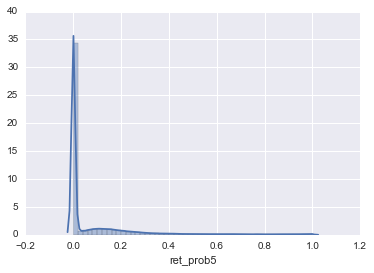

In [58]:
sns.distplot(ret_proba.ret_prob5)

In [60]:
em2002[['SAL1','MERIT1','PERF1']].describe()

,SAL1,MERIT1,PERF1
count,134266.000000,134266.000000,134266.000000
mean,54953.641146,1317.234767,1644.164758
std,31881.929036,1924.660917,1804.179432
min,0.000000,-45000.000000,0.000000
25%,31045.350000,0.160000,103.470000
50%,46552.930000,1105.620000,1183.435000
75%,73224.405000,1989.060000,2584.737500
max,725000.000000,35000.000000,56751.140000


In [61]:
em2002[['SAL1','MERIT1','PERF1']].quantile(0.02)

SAL1      12906.4
MERIT1        0.0
PERF1         0.0
dtype: float64